In [ ]:
!pip install split-folders

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import zipfile
import pathlib
import splitfolders

In [ ]:
zip_ref = zipfile.ZipFile("/content/DATASET_UANG.zip")
zip_ref.extractall()
zip_ref.close()

In [ ]:
!ls /content/DATASET_UANG

duapuluhribu  limapuluhribu  sepuluhribu  seribu
duaribu       limaribu	     seratusribu  tujuhpuluhlimaribu


In [ ]:
for dirpath, dirname, filename in os.walk("/content/DATASET_UANG"):
  print(f"There are {len(dirname)} and {len(filename)} in {dirpath} directory")

There are 8 and 0 in /content/rupiah directory
There are 0 and 1 in /content/rupiah/seribu directory
There are 0 and 1 in /content/rupiah/tujuhpuluhlimaribu directory
There are 0 and 1 in /content/rupiah/duaribu directory
There are 0 and 1 in /content/rupiah/limapuluhribu directory
There are 0 and 1 in /content/rupiah/seratusribu directory
There are 0 and 1 in /content/rupiah/sepuluhribu directory
There are 0 and 1 in /content/rupiah/duapuluhribu directory
There are 0 and 1 in /content/rupiah/limaribu directory


In [ ]:
path = pathlib.Path("/content/rupiah")
class_names = np.array(sorted([item.name for item in path.glob("*")]))
class_names

array(['duapuluhribu', 'duaribu', 'limapuluhribu', 'limaribu',
       'sepuluhribu', 'seratusribu', 'seribu', 'tujuhpuluhlimaribu'],
      dtype='<U18')

In [ ]:
splitfolders.ratio(input="/content/DATASET_UANG",
                   output="dataset_split",
                   seed=42,
                   ratio=(0.7, 0.3))

Copying files: 120 files [00:00, 3381.96 files/s]


In [ ]:
tf.random.set_seed(42)

train_dir = "/content/dataset_split/train"
val_dir = "/content/dataset_split/val"

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                rotation_range=0.2,
                                                                horizontal_flip=True)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               batch_size=16,
                                               seed=42)

val_data = val_datagen.flow_from_directory(val_dir,
                                           target_size=(224, 224),
                                           class_mode="categorical",
                                           batch_size=16,
                                           seed=42)

Found 80 images belonging to 8 classes.
Found 40 images belonging to 8 classes.


In [ ]:
class LrHistory(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs['lr'] = tf.keras.backend.get_value(self.model.optimizer.learning_rate)

lr_hist = LrHistory()

In [ ]:
def early_stopping():
  return tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                          restore_best_weights=True,
                                          patience=20)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

def reduce_lr():
  return ReduceLROnPlateau(
    monitor='val_loss',   # metrik yang dipantau
    factor=0.5,           # turunkan lr jadi 50% (misal 0.001 -> 0.0005)
    patience=3,           # jika 3 epoch berturut-turut val_loss tidak membaik
    min_lr=1e-6,          # lr minimum
    verbose=1
  )

In [ ]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same", input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same"),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same"),
    tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same"),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(len(class_names), activation="softmax")
])

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

history_model = model.fit(train_data,
                          epochs=50,
                          validation_data=val_data,
                          validation_steps=len(val_data),
                          callbacks=[lr_hist, early_stopping(), reduce_lr()])

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 562ms/step - accuracy: 0.1866 - loss: 2.0891 - val_accuracy: 0.1250 - val_loss: 2.0784 - lr: 0.0010 - learning_rate: 0.0010
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 330ms/step - accuracy: 0.1241 - loss: 2.0773 - val_accuracy: 0.1250 - val_loss: 2.0754 - lr: 0.0010 - learning_rate: 0.0010
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 384ms/step - accuracy: 0.1573 - loss: 2.0765 - val_accuracy: 0.1250 - val_loss: 2.0628 - lr: 0.0010 - learning_rate: 0.0010
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.0842 - loss: 2.0613
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step - accuracy: 0.0847 - loss: 2.0600 - val_accuracy: 0.1250 - val_loss: 1.9934 - lr: 0.0010 - learning_rate: 0.0010
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step - accuracy: 0.1616 - loss: 1.9828 - val_accuracy: 0.1250 - val_loss: 1.9173 - lr: 5.0000e-04 - learning_rate: 5.0000e-04
Epoch 6/50
5/5 ━━━━━━━━━━━━━

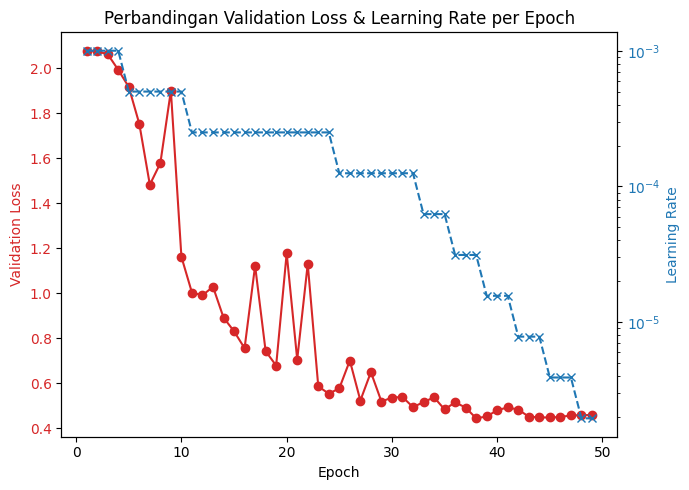

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ambil data dari history
epochs   = np.arange(len(history_model.history['val_loss'])) + 1
val_loss = history_model.history['val_loss']
lrs      = history_model.history['lr']

fig, ax1 = plt.subplots(figsize=(7,5))

# --- Plot Val Loss (sumbu kiri)
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Validation Loss', color=color)
ax1.plot(epochs, val_loss, color=color, marker='o', label='Val Loss')
ax1.tick_params(axis='y', labelcolor=color)

# --- Plot Learning Rate (sumbu kanan)
ax2 = ax1.twinx()  # buat sumbu Y kedua
color = 'tab:blue'
ax2.set_ylabel('Learning Rate', color=color)
ax2.plot(epochs, lrs, color=color, marker='x', linestyle='--', label='Learning Rate')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yscale('log')  # opsional: log scale biar lebih informatif

plt.title("Perbandingan Validation Loss & Learning Rate per Epoch")
plt.tight_layout()
plt.show()


In [ ]:
model.evaluate(val_data)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9234 - loss: 0.5565


[0.5196420550346375, 0.925000011920929]

In [ ]:
model.save("model_rupiah.keras")

In [ ]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  '''
  Reads and image from filename, turns it
  into a tensor and reshapes it to (img_shape, img_shape, colour_channels).
  '''
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode the read file into a tensor
  img = tf.image.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, size=[img_shape, img_shape])
  # Rescale the image
  img = img/255.
  # Return the tensor
  return img

In [ ]:
def pred_and_plot(model, filename, class_names=class_names):
  '''
  Imports an image located at filename, makes a prediction with model
  and plots the image with the predicted class as the title
  '''
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)
  pred = model.predict(tf.expand_dims(img, axis=0))
  pred_class_index = tf.argmax(pred[0])
  class_pred = class_names[pred_class_index]

  plt.imshow(img)
  plt.title(f"Prediction : {class_pred} with conviction : {tf.reduce_max(pred)*100:.2f}")
  plt.axis(False)
  plt.grid(False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


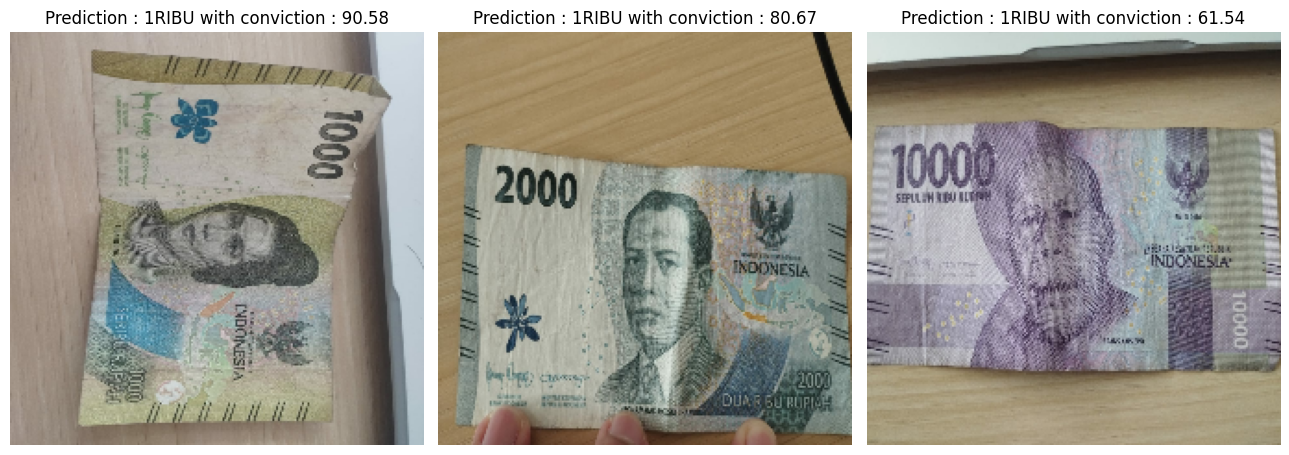

In [ ]:
list_img = ["/content/seribu.jpeg", "/content/duaribu.jpeg", "/content/sepuluhribu.jpeg"]

plt.figure(figsize=(13, 10))

for i, img in enumerate(list_img):
  plt.subplot(1, 3, i+1)
  pred_and_plot(model=model, filename=img, class_names=class_names)

plt.tight_layout()